## AI Image Captioning and Storytelling: using BLIP, LLaMA, TTS ...

> The current notebook is part of [AI Image Editing and Manipulation](https://github.com/afondiel/computer-vision-challenge/blob/main/L2_06_AI_Assisted_Image_Editing_and_Manipulation/) pipeline from [**Computer Vision Challenge**](https://github.com/afondiel/computer-vision-challenge).

<img width="680" height="240" src="https://github.com/afondiel/computer-vision-challenge/blob/main/L2_05_AI_Driven_Image_Captioning_and_Storytelling/docs/storyteller_pipeline.png?raw=true">


|--|Notebook|Demo (Gradio)|
|--|--|--|
||[![Open notebook in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/afondiel/computer-vision-challenge/blob/main/L2_05_AI_Driven_Image_Captioning_and_Storytelling/AI_Image_Captioner_Storyteller.ipynb)|[HF Space (Ongoing)](#)|

### Install Dependencies

In [30]:
# Install Hugging Face ecosystem
!pip -q install transformers accelerate huggingface_hub gradio datasets -U
# Install pytorch ecosystem
!pip -q install torchvision torchaudio fastai timm -U

### Import Libraries

In [31]:
import os
import json
import numpy as np
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration, pipeline
# from huggingface_hub import notebook_login
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import gradio as gr

### Preprocessing & Transformation

In [74]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# function().to(device)

# Set up device for computation
def get_device():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using {device}")
    return device

# Load the image from file
def load_image(image_path):
    image = Image.open(image_path)
    return image

# Load Image from url/path
def load_image(input_image):
  """
  Load an image from a URL or local path.

  Args:
    image: Either a URL string or a PIL.Image object.
  """
  if isinstance(input_image, str):
    # If image is a URL, open it
    try:
      response = requests.get(input_image, stream=True)
      response.raise_for_status()  # Raise an exception for bad status codes
      img = Image.open(BytesIO(response.content)).convert('RGB')
    except requests.exceptions.RequestException as e:
      print(f"Error loading image from URL: {e}")
      return
  elif isinstance(input_image, Image.Image):
    img = input_image
  else:
    print("Invalid image format. Please provide a URL or a PIL.Image object.")
    return
  return img

# Post-Precessing
def extract_story(story):
  start_marker = "<|assistant|>"
  start_index = story.find(start_marker) + len(start_marker)
  extracted_story = story[start_index:].strip()
  return extracted_story

### Storyteller Pipeline

In [33]:
# ------------------------------------------
# Generate Caption
# ------------------------------------------
def generate_caption(image_path, cap_prompt="A picture of"):
    cap_model_id = "Salesforce/blip-image-captioning-base"
    # Load the BLIP model and processor for image captioning
    processor = BlipProcessor.from_pretrained(cap_model_id)
    model = BlipForConditionalGeneration.from_pretrained(cap_model_id)

    # unconditional/conditional image captioning flag
    # cap_prompt="A picture of"

    # Load the image and prepare it for captioning
    inputs = processor(image_path, cap_prompt, return_tensors="pt")

    # Generate caption
    out = model.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True)

    return caption

In [34]:
# ------------------------------------------
# Generate Story
# ------------------------------------------
from transformers import pipeline
import torch

""""
  zephyr_storyteller
"""

# def zephyr_storyteller(story_model_id, caption):
def zephyr_storyteller(caption):

  story_model_id = "HuggingFaceH4/zephyr-7b-alpha"
  pipe = pipeline(
      "text-generation",
      model=story_model_id,
      torch_dtype=torch.float16, device_map="auto"
  )

  messages = [
      {
          "role": "system",
          "content": "You are a story teller. You can generate a short story based on a single narrative, the story should be no more than 30 words long",
      },
      {
          "role": "user",
          "content": str(caption)
      },
  ]
  prompt = pipe.tokenizer.apply_chat_template(
      messages,
      tokenize=False,
      add_generation_prompt=True
  )
  outputs = pipe(
      prompt,
      max_new_tokens=256,
      do_sample=True,
      temperature=0.7,
      top_k=50,
      top_p=0.95
  )
  # print(outputs[0]["generated_text"])

  return outputs[0]["generated_text"]

""""
  llama_storyteller
"""

def llama_storyteller(prompt: str):
  """
  Generate a response from the Llama model.

  Parameters:
      prompt (str): The user's input/question for the model.

  Returns:
      None: Prints the model's response.
  """
  # model = "meta-llama/Llama-2-7b-chat-hf"
  model = "meta-llama/Llama-2-7b-hf"

  llama_pipeline = pipeline(
    "text-generation", # LLM task
    model=model,
    torch_dtype=torch.bfloat16,
    device = -1, # or "cpu"
  )
  sequences = llama_pipeline(
      prompt,
      do_sample=True,
      top_k=10,
      num_return_sequences=1,
      eos_token_id=tokenizer.eos_token_id,
      max_length=256,
  )

  print("Llama 2 Storyteller:", sequences[0]['generated_text'])
  return sequences[0]['generated_text']


In [35]:

# ---------------------------------------
# llama2 using Tokenizer
# ---------------------------------------
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch

# def llama2_story(text):
#   model_id = "meta-llama/Llama-2-7b-chat-hf"
#       tokenizer = AutoTokenizer.from_pretrained(model_id)
#       model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float16, device_map="auto")

#   pipe = pipeline(
#           "text-generation",
#           model=model,
#           tokenizer=tokenizer,
#           torch_dtype=torch.float16,
#           device_map="auto",
#       )
#   # text = "I liked the movie, it was really..."
#   sequences = pipe(
#           text,
#           do_sample=True,
#           top_k=10,
#           num_return_sequences=1,
#           # eos_token_id=tokenizer.eos_token_id,
#           max_length=200,
#       )
#   print(sequences[0]["generated_text"])

In [36]:
# ------------------------------------
# Phi-3-mini-4k-instruct - Storyteller
# -----------------------------------

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

def Phi3_mini_storyteller(caption):

  torch.random.manual_seed(0)
  model_id = "microsoft/Phi-3-mini-4k-instruct" # gpu
  # model_id = "microsoft/Phi-3-mini-4k-instruct-onnx" # optimized cpu
  # model_id = "microsoft/Phi-3-mini-4k-instruct-gguf" # cpu

  model = AutoModelForCausalLM.from_pretrained(
      model=model_id,
      # device_map="cuda",  # gpu
      device_map="cpu",  # cpu
      torch_dtype="auto",
      trust_remote_code=True,
  )

  tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

  messages = [
      {"role": "system", "content": "You are a story teller; You can generate a short story based on a single narrative, the story should be no more than 280 characters long"},
      {"role": "user", "content": {caption}},
      # {"role": "assistant", "content": "Sure! Here are some ways to eat bananas and dragonfruits together: 1. Banana and dragonfruit smoothie: Blend bananas and dragonfruits together with some milk and honey. 2. Banana and dragonfruit salad: Mix sliced bananas and dragonfruits together with some lemon juice and honey."},
      # {"role": "user", "content": "What about solving an 2x + 3 = 7 equation?"},
  ]

  pipe = pipeline(
      "text-generation",
      model=model,
      tokenizer=tokenizer,
  )

  generation_args = {
      "max_new_tokens": 500,
      "return_full_text": False,
      "temperature": 0.0,
      "do_sample": False,
  }

  output = pipe(messages, **generation_args)
  # print(output[0]['generated_text'])
  return output[0]['generated_text']


In [37]:
!pip install git+https://github.com/coqui-ai/TTS -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [38]:
!curl -O https://raw.githubusercontent.com/afondiel/computer-vision-challenge/main/L2_05_AI_Driven_Image_Captioning_and_Storytelling/tools/voice.mp3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33663  100 33663    0     0  69463      0 --:--:-- --:--:-- --:--:-- 69408


In [89]:
# -------------------------------------
# Text to Audio usinf coqui/XTTS-v2
# -------------------------------------
from IPython.display import Audio
from TTS.api import TTS
# tts = TTS("tts_models/multilingual/multi-dataset/xtts_v2", gpu=True)

def play_story(
      text: str,
      audio_name="audio_story.mp3",
      speaker_wav: str = "voice.mp3",
      language: str="en",
    ):

  model_id="tts_models/multilingual/multi-dataset/xtts_v2"
  tts = TTS(model_id, gpu=False) # gpu=True, if gpu, gpu=False otherwise
  tts.tts_to_file(
    text=text,
    file_path=f"{audio_name}",
    speaker_wav=f"{speaker_wav}",
    language=f"{language}"
  )
  return audio_name


#### Listen to cool Stories from your Images
> **WARNING**

- You'll need a personal Hugging Face TOKEN to run the Storyteller with llama2
- You can very easily create one here: https://huggingface.co/docs/hub/security-tokens

In [40]:
# ----------------------------------------------
# Read and Listen to your stories in Real-Time
# ----------------------------------------------
from IPython.display import Audio
import requests
from google.colab import userdata

API_URL = "https://api-inference.huggingface.co/models/meta-llama/Meta-Llama-3.1-8B-Instruct"
HF_COLAB_W = userdata.get('HF_COLAB_W')
headers = {"Authorization": f"Bearer {HF_COLAB_W}"}

def query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()

# ------------------------------------------
# Listen to story in Real-Time
# ------------------------------------------
def play_story_realtime(
    text: str,
    audio_name="audio_story.mp3",
    speaker_wav: str = "./voice.mp3",
    language: str="en"
  ):

  data = query({
      "inputs": f"{text}",
      "parameters": {
        "do_sample": True,
        "top_p": 0.7,
        "temperature": 0.7,
        # "top_k": 50,
        # "max_new_tokens": 512,
        # "repetition_penalty": 1.03,
        # "return_full_text": False,
      }
  })
  output_message = data[0]['generated_text']
  # print(output_message)
  # play your story
  play_story(output_message, audio_name, language="en")
  return Audio(f"{audio_name}")

# ------------------------------------------
# Read to story in Real-Time
# ------------------------------------------

def read_story_realtime(text: str, language: str="en"):

  data = query({
      "inputs": f"{text}",
      "parameters": {
        "do_sample": True,
        "top_p": 0.7,
        "temperature": 0.7,
        # "top_k": 50,
        # "max_new_tokens": 512,
        # "repetition_penalty": 1.03,
        # "return_full_text": False,
      }
  })
  output_message = data[0]['generated_text']
  print(output_message)
  # Read your story
  return output_message

### Main: running the App

In [41]:
import os
from huggingface_hub import notebook_login, login

# ------------------------------------------
# Login to Hugging Face
# ------------------------------------------
# Required when training models/data that are gated on HuggingFace, like Llama 2.
# notebook_login()


In [28]:
# Test

# prompt = "Which planet is the closest to the sun?"

# Zephyr Storyteller
# zephyr_storyteller(prompt)
# Llma2 Storyteller
# llama_storyteller(prompt)

In [43]:
# Get Device
get_device()

# uploaded image
# from google.colab import files
# uploaded = files.upload()

# Get image
# image_path = list(uploaded.keys())[0]

img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg'
image_path = load_image(img_url)

# ------------------------------------------
# Generate caption
# ------------------------------------------
caption = generate_caption(image_path)

# ------------------------------------------
# Generate story
# ------------------------------------------
story = zephyr_storyteller(caption)
# story = llama_storyteller(caption)

# ------------------------------------------
# Play the story
# ------------------------------------------
# clean up
story_clean = extract_story(story)
audio_story = play_story(text=story_clean)
# audio_story = play_story(text=story_clean, audio_name="audio_story.mp3", language="en")

# ------------------------------------------
# Read to story in Real-Time
# ------------------------------------------
# Audio story
# read_story_rt = read_story_realtime(story, audio_name="audio_story.mp3", language="en")

# ------------------------------------------
# Listen to story in Real-Time
# ------------------------------------------
# Audio story
# play_story_rt = play_story_realtime(story, audio_name="audio_story.mp3", language="en")



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

 > You must confirm the following:
 | > "I have purchased a commercial license from Coqui: licensing@coqui.ai"
 | > "Otherwise, I agree to the terms of the non-commercial CPML: https://coqui.ai/cpml" - [y/n]
 | | > y
 > Downloading model to /root/.local/share/tts/tts_models--multilingual--multi-dataset--xtts_v2


100%|█████████▉| 1.86G/1.87G [01:04<00:00, 29.6MiB/s]
100%|██████████| 1.87G/1.87G [01:04<00:00, 28.8MiB/s]
100%|██████████| 4.37k/4.37k [00:00<00:00, 11.3kiB/s]
 85%|████████▌ | 308k/361k [00:00<00:00, 704kiB/s]
100%|██████████| 361k/361k [00:00<00:00, 394kiB/s]
100%|██████████| 32.0/32.0 [00:00<00:00, 50.4iB/s]
 81%|████████  | 6.24M/7.75M [00:00<00:00, 32.5MiB/s]

 > Model's license - CPML
 > Check https://coqui.ai/cpml.txt for more info.
 > Using model: xtts


/usr/local/lib/python3.10/dist-packages/TTS/tts/layers/xtts/xtts_manager.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.speakers = torch.load(speaker_file_path)
10

 > Text splitted to sentences.
['<|system|>', 'You are a story teller; You can generate a short story based on a single narrative, the story should be no more than 280 characters long', '<|user|>', 'a picture of a woman and her dog on the beach', '<|assistant|>', '"Sun-kissed, sandy paws, tail wagging high. She smiles, soaking in the sea breeze, grateful for this moment with her furry friend." (277 characters)']


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


 > Processing time: 102.45323348045349
 > Real-time factor: 2.918786174189647
Generated Caption: a picture of a woman and her dog on the beach

Generated Story: <|system|>
You are a story teller; You can generate a short story based on a single narrative, the story should be no more than 280 characters long</s>
<|user|>
a picture of a woman and her dog on the beach</s>
<|assistant|>
"Sun-kissed, sandy paws, tail wagging high. She smiles, soaking in the sea breeze, grateful for this moment with her furry friend." (277 characters)

Audio Story: <IPython.lib.display.Audio object>


### Outputs & Visualization

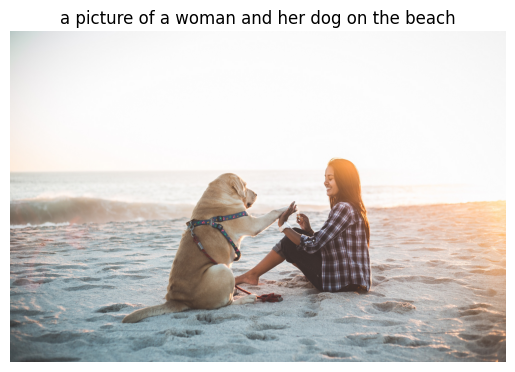

In [68]:
# display image
%matplotlib inline
# plt.figure(figsize=(5, 5))
plt.imshow(image_path)
plt.title(f"{caption}")
plt.axis("off")
plt.show()


In [69]:
# Generate a fun story based on the image.
# Display the results
story_clean = extract_story(story)

# print("Generated Caption:", caption)
print("\nGenerated Story:", story_clean)



Generated Story: 


In [90]:
# Listen to your stories
print("\nAudio Story:")
Audio(audio_story)



Audio Story:


### App Demo using Gradio

In [93]:
# prompt: write a gradio code to demo this project. Remember the system takes a an input image from url or uploaded and generate a caption, a story and audio

def image_captioning_storyteller(input_image):
  # Load Image from url
  image = load_image(input_image)
  print(image)

  # Generate caption
  caption = generate_caption(image)

  # Generate story
  story = zephyr_storyteller(caption)

  # clean up
  story_clean = extract_story(story)

  # Play the story
  audio_story = play_story(text=story_clean)

  return caption, story_clean, audio_story

# Create the Gradio interface
demo = gr.Interface(
    fn=image_captioning_storyteller,
    inputs=gr.Image(type="pil", label="Upload an image"),
    outputs=[
        gr.Textbox(label="Generated Caption"),
        gr.Textbox(label="Generated Story"),
        gr.Audio(label="Audio Story"),
    ],
    title="AI Image Captioning and Storytelling",
    description="Generate captions and stories from your images.",
)



In [94]:
# Launch Demo
demo.queue.launch(share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://2eaad22d9979543cb4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


<PIL.Image.Image image mode=RGB size=2048x1365 at 0x7F972EEB6440>


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

 > tts_models/multilingual/multi-dataset/xtts_v2 is already downloaded.
 > Using model: xtts


/usr/local/lib/python3.10/dist-packages/TTS/tts/layers/xtts/xtts_manager.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.speakers = torch.load(speaker_file_path)
/u

 > Text splitted to sentences.
['"Sun-kissed sand, waves crashing, she walks with her best friend. Their love, a bond unbroken, as they roam, carefree and content." (279 characters)']
 > Processing time: 70.15800952911377
 > Real-time factor: 4.325437609372787
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7861 <> https://2eaad22d9979543cb4.gradio.live


## References

Docs:
- https://huggingface.co/tasks/image-to-text

- https://huggingface.co/tasks/image-text-to-text

Multimodality:
- [multimodal AI. open-source. in a nutshell- @Merve Noyan](https://youtu.be/IoGaGfU1CIg?si=BM64g7o0FjRW1rUl)


Benchmark Models & Projects

- https://paperswithcode.com/task/image-captioning
- https://medium.com/alameda-dev/use-ai-to-create-a-story-from-an-image-8ec5d8c50c0e
- https://medium.com/@fradin.antoine17/3-ways-to-set-up-llama-2-locally-on-cpu-part-3-hugging-face-cd06e0440a5b


HF Models:
- https://huggingface.co/models?pipeline_tag=image-to-text

- https://huggingface.co/Salesforce/blip-image-captioning-base

- https://huggingface.co/nlpconnect/vit-gpt2-image-captioning


Papers:
- https://aclanthology.org/N16-1147v1.pdf